In [647]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# set font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.size'] = 12
# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

In [648]:
  
engine = create_engine('sqlite:///train.db')
traindata =pd.read_sql('''
SELECT
    version,
    rollbacks,
    rollbacks_time,
    group2_delay_days,
    (group0_delay_days +
     group1_delay_days +
     group2_delay_days) as total_delay,
    total_time as train_total_time,
    (select count(*) from blocker b where b.train_id = t.id) as blockers,
    (select count(*) from blocker b where b.train_id = t.id and resolved = 1) as blockers_resolved,
    patches,
    (select avg(time_in_review) from patch p where p.train_id = t.id) as avg_time_in_review,
    (select avg(comments) from patch where patch.train_id = t.id) as avg_comments_per_patch,
    (select sum(loc) from bug_patch where bug_patch.train_id = t.id) as total_loc_per_train_bug,
    (select avg(loc) from bug_patch where bug_patch.train_id = t.id) as avg_loc_per_train_bug,
    (select avg(loc) from patch where patch.train_id = t.id) as avg_loc_per_train_patch,
    (select sum(loc) from patch where patch.train_id = t.id) as total_loc_per_train_patch,
    (select GROUP_CONCAT(title) from bug_train join bug on bug_train.bug_id=bug.id where bug_train.train_id = t.id group by train_id) as bug_titles,
    (select max(start_time - created) from patch p where p.train_id = t.id) as max_cycle_time,
    (select count(*) from blocker b where b.train_id = t.id and group_blocked = 0) as group0_blockers,
    (select count(*) from blocker b where b.train_id = t.id and group_blocked = 1) as group1_blockers,
    (select count(*) from blocker b where b.train_id = t.id and group_blocked = 2) as group2_blockers,
    (select count(*) from blocker b where b.train_id = t.id and group_blocked = -1) as earlier_blockers,
    start_time
FROM train t
''', engine)


In [649]:
traindata["bug_titles"].to_csv('bugs.csv')

In [650]:
traindata['start_time']=pd.to_datetime(traindata['start_time'], unit='s')

In [651]:
traindata['start_month']=pd.to_datetime(traindata['start_time'].apply(lambda x: x.strftime('%Y-%m'))).apply(lambda date: date.toordinal())

In [652]:
traindata['start_quarter']=traindata['start_time'].dt.to_period('Q')
traindata['start_quarter']=traindata['start_quarter'].apply(lambda date: date.to_timestamp().toordinal())

In [653]:
traindata['patches_quantized']=[i/float(100) for i in traindata['patches']]
traindata['comments_quantized']=[i if str(i)!='nan' else 0 for i in traindata['avg_comments_per_patch']]
traindata['loc_quantized']=[0 if str(i)=='nan' else 100*round(i/float(100)) for i in traindata['total_loc_per_train_patch']]
traindata['avg_loc_quantized']=[0 if str(i)=='nan' else 100*round(i/float(100)) for i in traindata['avg_loc_per_train_patch']]
traindata['loc_bug_quantized']=[0 if str(i)=='nan' else 100*round(i/float(100)) for i in traindata['total_loc_per_train_bug']]
traindata['avg_loc_bug_quantized']=[0 if str(i)=='nan' else 100*round(i/float(100)) for i in traindata['avg_loc_per_train_bug']]


In [654]:
#converting total time to days
traindata["train_total_time_days"]=[round((i/float(3600))/24) for i in traindata["train_total_time"]]
traindata["train_total_time_days_cont"]=[(i/float(3600))/24 for i in traindata["train_total_time"]]


## Data checks
Anything strange or interesting in the distribution?

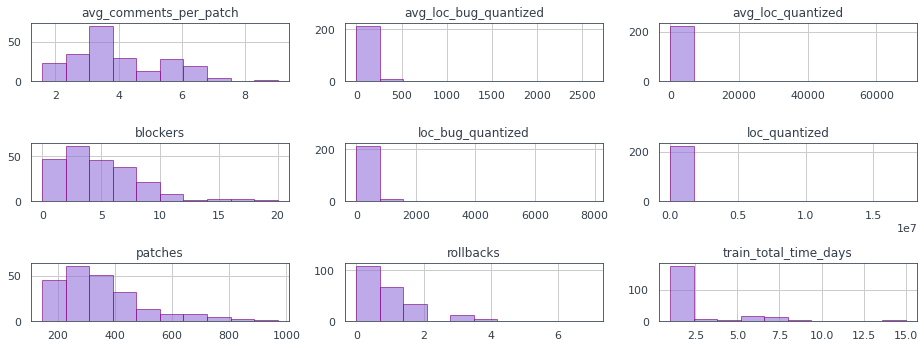

In [655]:
fig, ax= plt.subplots(3,3,figsize=(13,5))
plot=traindata[['patches','avg_comments_per_patch','train_total_time_days',
                'loc_quantized','avg_loc_quantized','loc_bug_quantized',
                'avg_loc_bug_quantized','rollbacks','blockers']].hist(ax=ax,alpha=0.6,color='mediumpurple',edgecolor='purple')
plt.tight_layout()
plt.show()

#### Some variables seem to have bimodal distribution (which is good, because we can draw natural cutoff for metrics)
#### But LOC variables clearly have outliers. We have to remove them!
### Distribution of actual problems: blockers, resolved blcokers, rollbacks

<Figure size 432x288 with 0 Axes>

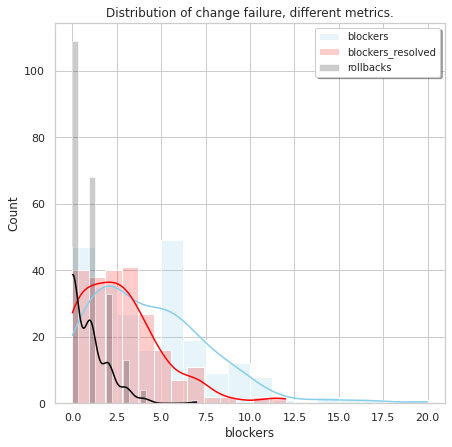

In [656]:
plt.clf()
sns.set(style="whitegrid")

colors=[]

fig,  ax= plt.subplots(figsize=(7, 7))
for a,c in zip(['blockers','blockers_resolved','rollbacks'],["skyblue","red","black"]):
    ax=sns.histplot(data=traindata,x=a,label=a,kde=True,color=c,alpha=0.2)
plt.title('Distribution of change failure, different metrics.')
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')



plt.show()

#### The above shows that unresolved blockers and rollbacks are power laws: majority of trains has 0 rollbacks, while the rest slowly decay to higher values. It will be difficult to draw average stats from such distributions. Blockers and resolved blockers distribution is a bit more "gaussian", so looking at an average threshold should be easier.

### Distribution of total time and total delays


<Figure size 432x288 with 0 Axes>

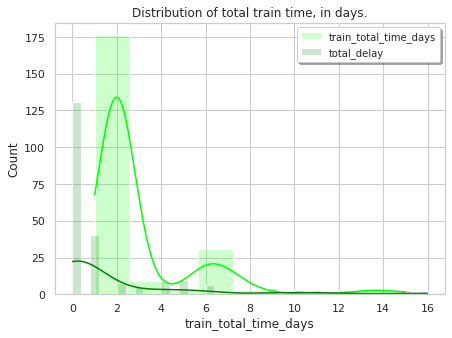

In [657]:

plt.clf()
sns.set(style="whitegrid")

colors=[]

fig,  ax= plt.subplots(figsize=(7, 5))
for a,c in zip(['train_total_time_days','total_delay'],["lime","green"]):
    ax=sns.histplot(data=traindata,x=a,label=a,kde=True,color=c,alpha=0.2)
plt.title('Distribution of total train time, in days.')
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')



plt.show()

#### These seem to have a more bimodal distribution: delays higher than 2 days or total train days higher than 4 days are more rare.
### Distribution of LOC in train and bug patches
Let's see where we need to clip these distributions to smooth outliers

<Figure size 432x288 with 0 Axes>

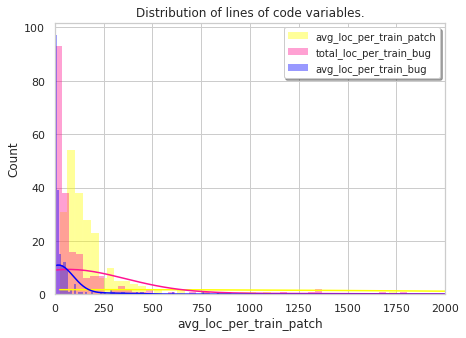

In [658]:
plt.clf()
sns.set(style="whitegrid")

colors=[]

fig,  ax= plt.subplots(figsize=(7, 5))
for a,c in zip(['avg_loc_per_train_patch','total_loc_per_train_bug','avg_loc_per_train_bug'],["yellow","deeppink","blue"]):
    ax=sns.histplot(data=traindata,x=a,label=a,kde=True,color=c,alpha=0.4)
plt.title('Distribution of lines of code variables.')
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')

ax.set_xlim([0,2000])


plt.show()

#### Form the above and other computations, 1000 seem to be a good threshold, let's see the total LOC per train patch (which is on a different scale)

<Figure size 432x288 with 0 Axes>

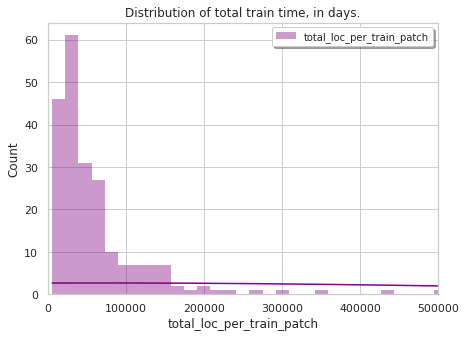

In [659]:
plt.clf()
sns.set(style="whitegrid")

colors=[]

fig,  ax= plt.subplots(figsize=(7, 5))
for a,c in zip(['total_loc_per_train_patch'],["purple"]):
    ax=sns.histplot(data=traindata,x=a,label=a,kde=True,color=c,alpha=0.4)
plt.title('Distribution of total train time, in days.')
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')

ax.set_xlim([0,500000])


plt.show()

#### Form the above and other computations, 300,000 seem to be a good threshold, let's now clip the data!

In [660]:
#clipping data to avoid outliers effects
for a,c in zip(['total_loc_per_train_patch','avg_loc_per_train_patch','total_loc_per_train_bug','avg_loc_per_train_bug'],[300000]+[1000]*3):
    traindata[a]=[i if i <c else c for i in traindata[a]]


In [661]:
#clipping data to avoid outliers effects
for a,c in zip(['loc_quantized','avg_loc_quantized','loc_bug_quantized','avg_loc_bug_quantized',],[300000]+[1000]*3):
    traindata[a]=[i if i <c else c for i in traindata[a]]


## Evolution over time
For some of our variables.
### Number of patches vs number of comments per patch

<Figure size 432x288 with 0 Axes>

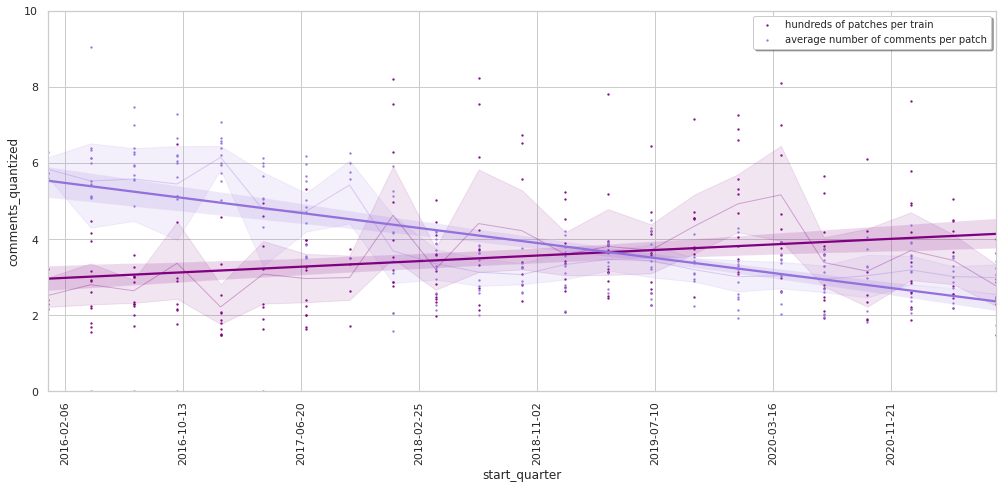

In [662]:
from datetime import date
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(17, 7))

sns.regplot(x="start_quarter", y="patches_quantized",data=traindata,color="purple", label="hundreds of patches per train",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="patches_quantized",data=traindata,color="purple", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
sns.regplot(x="start_quarter", y="comments_quantized",data=traindata,color="mediumpurple", label="average number of comments per patch",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="comments_quantized",data=traindata,color="mediumpurple", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
ax.set_ylim([0,10])
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
x=plt.xticks(rotation=90)


#### Number of patches is marginally increasing over time, while the average number of comments per patch is decreasing substantially.
Is it behavior due to the pax becoming smaller over time? From the plot below, it seems that the average LOC per train is stable over time, while the total number of LOC in a train is maybe slightly increasing.

<Figure size 432x288 with 0 Axes>

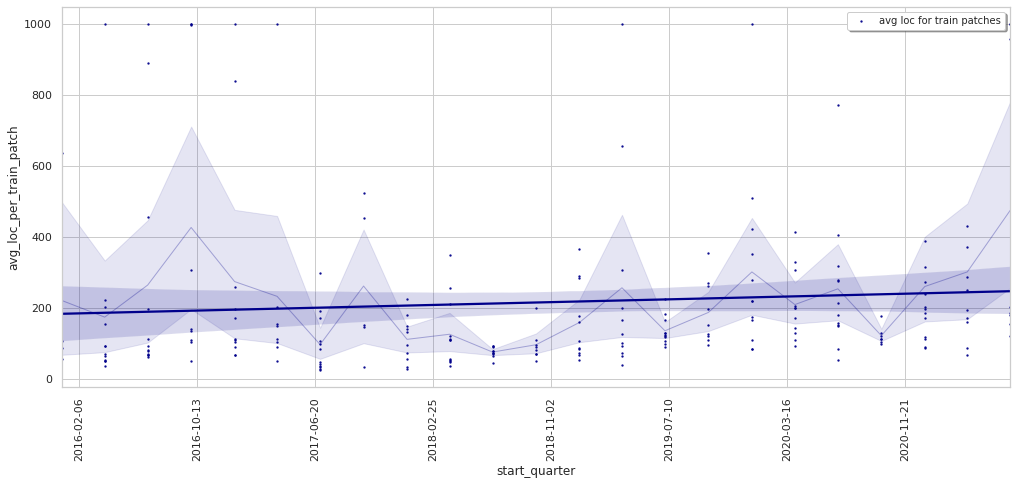

In [663]:
from datetime import date
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(17, 7))

#sns.regplot(x="start_quarter", y="total_loc_per_train_patch",data=traindata,color="blue", label="avg loc per bug patch",scatter_kws={'s':2})
#sns.lineplot(x="start_quarter", y="total_loc_per_train_patch",data=traindata,color="blue", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
sns.regplot(x="start_quarter", y="avg_loc_per_train_patch",data=traindata,color="darkblue", label="avg loc for train patches",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="avg_loc_per_train_patch",data=traindata,color="darkblue", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
x=plt.xticks(rotation=90)


<Figure size 432x288 with 0 Axes>

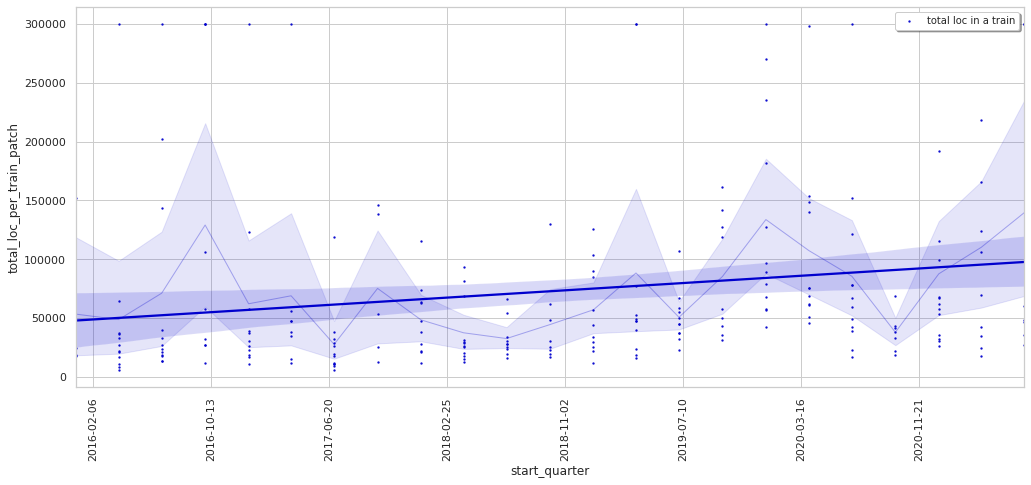

In [664]:
from datetime import date
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(17, 7))

#sns.regplot(x="start_quarter", y="total_loc_per_train_patch",data=traindata,color="blue", label="avg loc per bug patch",scatter_kws={'s':2})
#sns.lineplot(x="start_quarter", y="total_loc_per_train_patch",data=traindata,color="blue", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
sns.regplot(x="start_quarter", y="total_loc_per_train_patch",data=traindata,color="mediumblue", label="total loc in a train",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="total_loc_per_train_patch",data=traindata,color="mediumblue", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
x=plt.xticks(rotation=90)


### Number of patches vs number of comments per patch
There doesn't seem to be a major trand for LOC per train bug, so the effort in the response doesn't seem to be increasing over time.

<Figure size 432x288 with 0 Axes>

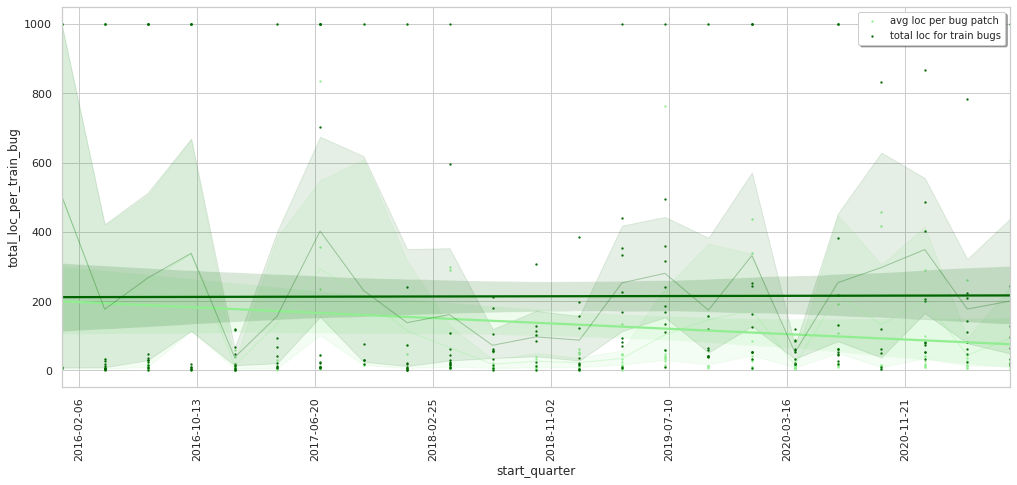

In [665]:
from datetime import date
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(17, 7))

sns.regplot(x="start_quarter", y="avg_loc_per_train_bug",data=traindata,color="lightgreen", label="avg loc per bug patch",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="avg_loc_per_train_bug",data=traindata,color="lightgreen", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
sns.regplot(x="start_quarter", y="total_loc_per_train_bug",data=traindata,color="darkgreen", label="total loc for train bugs",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="total_loc_per_train_bug",data=traindata,color="darkgreen", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
x=plt.xticks(rotation=90)


<Figure size 432x288 with 0 Axes>

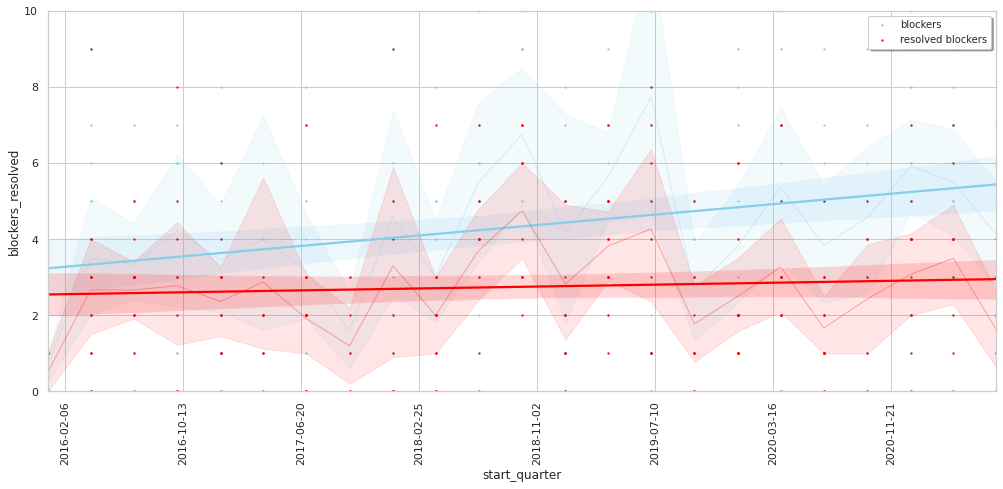

In [666]:
from datetime import date
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(17, 7))

sns.regplot(x="start_quarter", y="blockers",data=traindata,color="skyblue", label="blockers",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="blockers",data=traindata,color="skyblue", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
sns.regplot(x="start_quarter", y="blockers_resolved",data=traindata,color="red", label="resolved blockers",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="blockers_resolved",data=traindata,color="red", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
ax.set_ylim([0,10])
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
x=plt.xticks(rotation=90)


#### The number of  blockers is also increasing over time, but the average number of resolved  blockers is steady, and around 2.5/3 in average per train. Doe this correspond to the max capactiy of the team to solve blockers?

<Figure size 432x288 with 0 Axes>

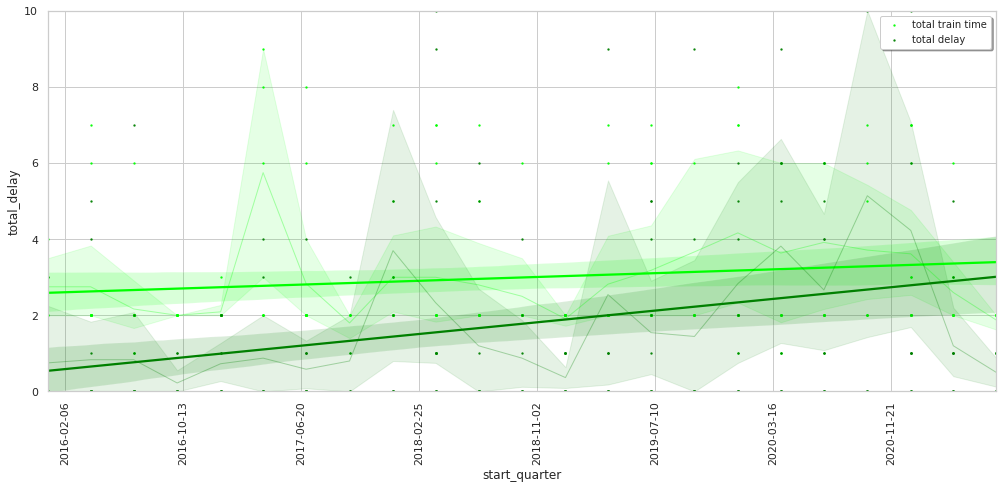

In [667]:
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(17, 7))

sns.regplot(x="start_quarter", y="train_total_time_days",data=traindata,color="lime", label="total train time",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="train_total_time_days",data=traindata,color="lime", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
sns.regplot(x="start_quarter", y="total_delay",data=traindata,color="green", label="total delay",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="total_delay",data=traindata,color="green", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
ax.set_ylim([0,10])
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
x=plt.xticks(rotation=90)

#### Similarly, the overall total train time and total delay is increasing over time

## Correlation between variables
### At train level

In [668]:
from scipy.stats import pearsonr

def pearsonr_pval(x,y):
    r=pearsonr(x,y)
    return r[0] if r[1]<0.05 else 0

<AxesSubplot:>

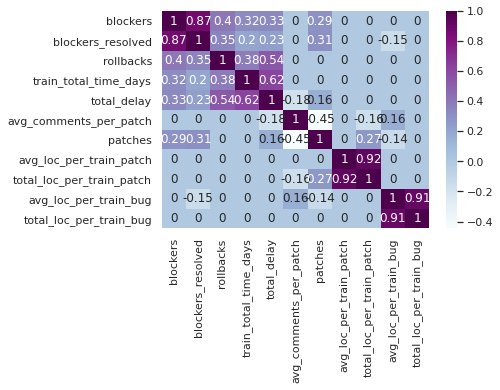

In [669]:
corr = traindata[["blockers","blockers_resolved","rollbacks","train_total_time_days","total_delay","avg_comments_per_patch","patches","avg_loc_per_train_patch","total_loc_per_train_patch","avg_loc_per_train_bug","total_loc_per_train_bug"]].corr(method=pearsonr_pval)
sns.heatmap(corr, cmap="BuPu", annot=True)


### Aggregated by Quarter
#### We see similar trend: blockers (especially the unresolved) and delay negatively correlate with average comments/patch and positively correlate with number of patches. From these correlations we can also see the steady decrease of average number of comments per patch over time (-0.84 correlation with start_quarter) and the increase of number of patches over time.
#### *There seems to be no effect of the tota/avg loc per train patch on the number of blockers or rollbacks*

<AxesSubplot:>

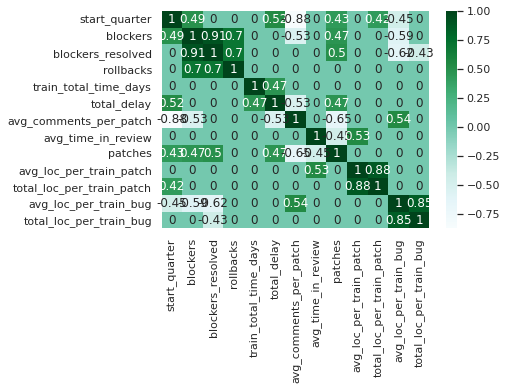

In [670]:
corr = traindata[["blockers","blockers_resolved","rollbacks","train_total_time_days","total_delay","avg_comments_per_patch","avg_time_in_review","patches","start_quarter","avg_loc_per_train_patch","total_loc_per_train_patch","avg_loc_per_train_bug","total_loc_per_train_bug"]].groupby("start_quarter").mean().reset_index().corr(method=pearsonr_pval)
sns.heatmap(corr, cmap="BuGn", annot=True)


### Which type of blocker is more highly related with total train time?
Group 1 blockers, it seems

<Figure size 432x288 with 0 Axes>

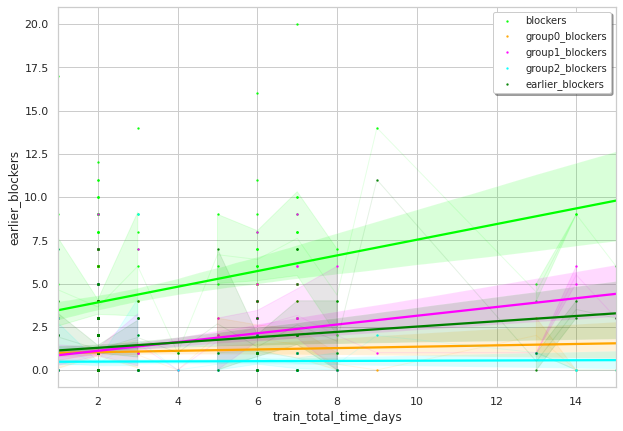

In [671]:
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(10, 7))

for a,c in zip(['blockers','group0_blockers','group1_blockers','group2_blockers','earlier_blockers'],["lime","orange","magenta","aqua","green"]):
    sns.lineplot(x="train_total_time_days", y=a,data=traindata,color=c,linewidth=1,alpha=0.1,err_kws={'alpha':0.1})
    sns.regplot(x="train_total_time_days", y=a,data=traindata,color=c, label=a,scatter_kws={'s':2})

#sns.lineplot(x="train_total_time_days", y="patches_hundreds",data=traindata,color="aqua", label= "patches")
#sns.lineplot(x="patches_quantized", y="rollbacks",data=traindata,color="black", label="rollbacks")#sns.lineplot(x="patches", y="rollbacks",data=traindata,color="black", label="rollbacks")
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')


<Figure size 432x288 with 0 Axes>

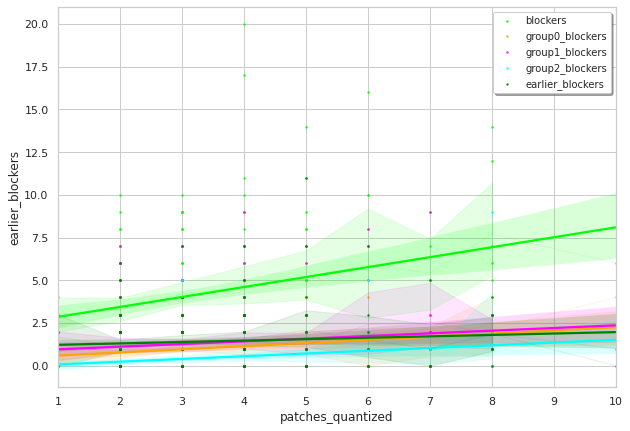

In [672]:
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(10, 7))

traindata["patches_quantized"]=[round(i) for i in traindata["patches_quantized"]]
for a,c in zip(['blockers','group0_blockers','group1_blockers','group2_blockers','earlier_blockers'],["lime","orange","magenta","aqua","green"]):
    sns.lineplot(x="patches_quantized", y=a,data=traindata,color=c,linewidth=1,alpha=0.1,err_kws={'alpha':0.1})
    sns.regplot(x="patches_quantized", y=a,data=traindata,color=c, label=a,scatter_kws={'s':2})

#sns.lineplot(x="train_total_time_days", y="patches_hundreds",data=traindata,color="aqua", label= "patches")
#sns.lineplot(x="patches_quantized", y="rollbacks",data=traindata,color="black", label="rollbacks")#sns.lineplot(x="patches", y="rollbacks",data=traindata,color="black", label="rollbacks")
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')


## Metrics related to (resolved) blockers
Blockers seem to be a clear indicator of failure

In [673]:
traindata['ratio_blockers']=[i/(float(j)) for i,j in zip(traindata['blockers'],traindata['patches'])]
traindata['ratio_blockers_resolved']=[i/(float(j)) for i,j in zip(traindata['blockers_resolved'],traindata['patches'])]
traindata['more_than_2_blockers']=[1 if i>2 else 0 for i in traindata['blockers']]
traindata['more_than_6_blockers']=[1 if i>6 else 0 for i in traindata['blockers']]
traindata['more_than_2_resolved_blockers']=[1 if i>2 else 0 for i in traindata['blockers_resolved']]
traindata['more_than_6_resolved_blockers']=[1 if i>6 else 0 for i in traindata['blockers_resolved']]


In [674]:
traindata[['ratio_blockers','ratio_blockers_resolved','more_than_2_blockers','more_than_6_blockers']].mean()

ratio_blockers             0.013246
ratio_blockers_resolved    0.008269
more_than_2_blockers       0.640351
more_than_6_blockers       0.236842
dtype: float64

### 1: the most intutitive - what is the ratio of (resolved) blockers vs unresolved patches?

<Figure size 432x288 with 0 Axes>

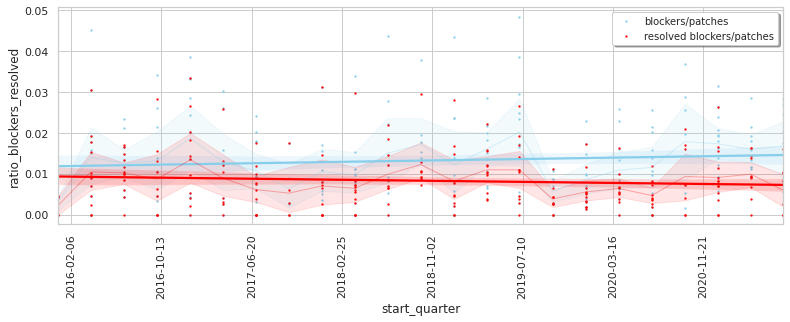

In [675]:
from datetime import date
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(13, 4))

sns.regplot(x="start_quarter", y="ratio_blockers",data=traindata,color="skyblue", label="blockers/patches",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="ratio_blockers",data=traindata,color="skyblue", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
sns.regplot(x="start_quarter", y="ratio_blockers_resolved",data=traindata,color="red", label="resolved blockers/patches",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="ratio_blockers_resolved",data=traindata,color="red", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
x=plt.xticks(rotation=90)


#### This metric doesn't seem to be very informative, the large number of patches at the denominator makes the metric value very small, hence the metric shows very small fluctuations, might not be ideal to reflect change failure percentage.

### 2: What is the percentage of trains with more than X (2,6) blockers, each quarter?

In [350]:
# two: %of trains per quarter with more than X (unresolved) blockers
# 3: semester window
# 4: %of trains per quarter with more than X delays
# 5: semester window

<Figure size 432x288 with 0 Axes>

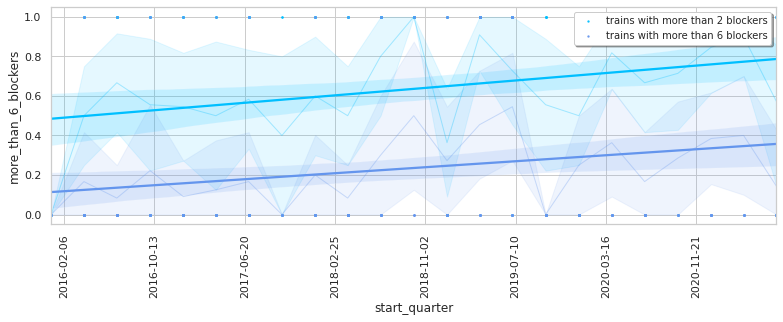

In [351]:
from datetime import date
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(13, 4))

sns.regplot(x="start_quarter", y="more_than_2_blockers",data=traindata,color="deepskyblue", label="trains with more than 2 blockers",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="more_than_2_blockers",data=traindata,color="deepskyblue", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
sns.regplot(x="start_quarter", y="more_than_6_blockers",data=traindata,color="cornflowerblue", label="trains with more than 6 blockers",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="more_than_6_blockers",data=traindata,color="cornflowerblue", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
x=plt.xticks(rotation=90)


<Figure size 432x288 with 0 Axes>

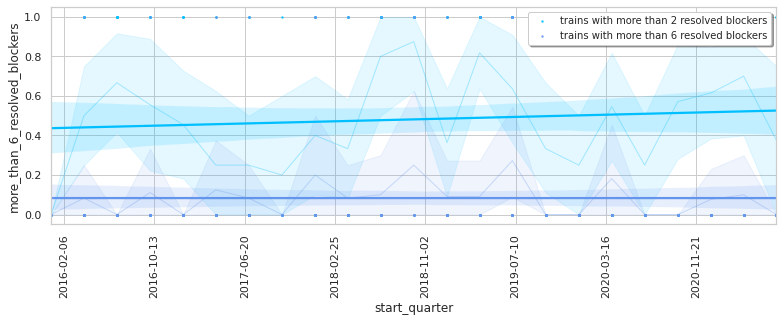

In [579]:
from datetime import date
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(13, 4))

sns.regplot(x="start_quarter", y="more_than_2_resolved_blockers",data=traindata,color="deepskyblue", label="trains with more than 2 resolved blockers",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="more_than_2_resolved_blockers",data=traindata,color="deepskyblue", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
sns.regplot(x="start_quarter", y="more_than_6_resolved_blockers",data=traindata,color="cornflowerblue", label="trains with more than 6 resolved blockers",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="more_than_6_resolved_blockers",data=traindata,color="cornflowerblue", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
x=plt.xticks(rotation=90)


#### This is slightly better: the variation is more visible, but still too sensitive to the small number of trains each quarter: the maximum is 12! The _resolved blocker_ variable is still very flat though
### 3: Rolling percentage of trains with more than X (resolved) blockers, in the past 6 months.

In [616]:
import dateutil.relativedelta
semester=dateutil.relativedelta.relativedelta(months=6)
traindata["start_month_t"]=traindata["start_month"].apply(lambda item: date.fromordinal(int(item)))
traindata["more_2_blockers_6_months"]=[len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>=(i-semester)) & (traindata["blockers"]>2)]["blockers"])/len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester))]) for i in traindata["start_month_t"]]
traindata["more_6_blockers_6_months"]=[len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>=(i-semester)) & (traindata["blockers"]>6)]["blockers"])/len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester))]) for i in traindata["start_month_t"]]
traindata["more_3_blockers_6_months"]=[len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>=(i-semester)) & (traindata["blockers"]>3)]["blockers"])/len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester))]) for i in traindata["start_month_t"]]
traindata["more_2_resolved_blockers_6_months"]=[len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>=(i-semester)) & (traindata["blockers_resolved"]>2)]["blockers_resolved"])/len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester))]) for i in traindata["start_month_t"]]
traindata["more_6_resolved_blockers_6_months"]=[len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>=(i-semester)) & (traindata["blockers_resolved"]>6)]["blockers_resolved"])/len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester))]) for i in traindata["start_month_t"]]
traindata["more_3_resolved_blockers_6_months"]=[len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>=(i-semester)) & (traindata["blockers_resolved"]>3)]["blockers_resolved"])/len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester))]) for i in traindata["start_month_t"]]


(0.0, 1.0)

<Figure size 432x288 with 0 Axes>

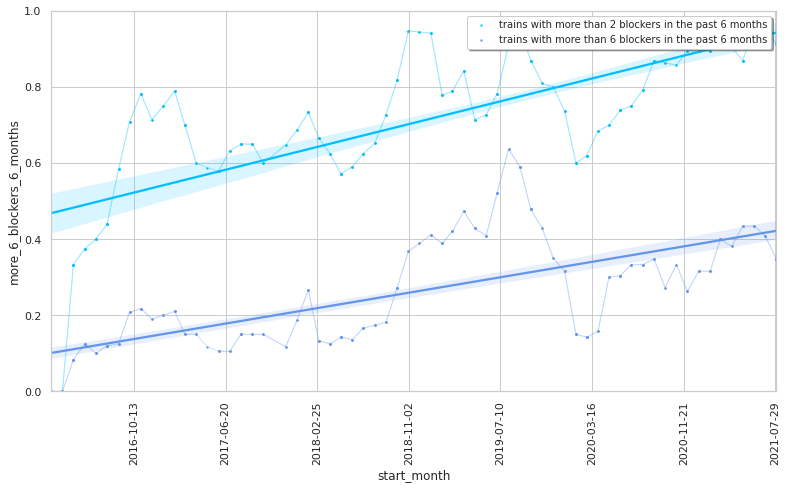

In [621]:
from datetime import date
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(13, 7))
sns.regplot(x="start_month", y="more_2_blockers_6_months",data=traindata,color="deepskyblue", label="trains with more than 2 blockers in the past 6 months",scatter_kws={'s':2})
sns.lineplot(x="start_month", y="more_2_blockers_6_months",data=traindata,color="deepskyblue", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
sns.regplot(x="start_month", y="more_6_blockers_6_months",data=traindata,color="cornflowerblue", label="trains with more than 6 blockers in the past 6 months",scatter_kws={'s':2})
sns.lineplot(x="start_month", y="more_6_blockers_6_months",data=traindata,color="cornflowerblue", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
x=plt.xticks(rotation=90)
ax.set_ylim([0,1])


#### This is more robust: we see a steady increase of both lines: as of now, about 80% of trains in 6 months have more than 2 blockers, and about 35% have more than 6. 
#### Let's now look at the same metric, but using _resolved blockers_ only.

(0.0, 1.0)

<Figure size 432x288 with 0 Axes>

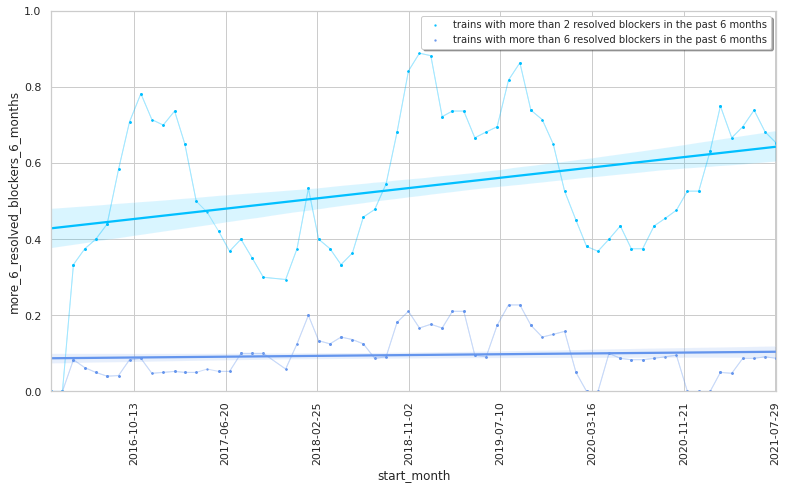

In [622]:
from datetime import date
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(13, 7))

sns.regplot(x="start_month", y="more_2_resolved_blockers_6_months",data=traindata,color="deepskyblue", label="trains with more than 2 resolved blockers in the past 6 months",scatter_kws={'s':2})
sns.lineplot(x="start_month", y="more_2_resolved_blockers_6_months",data=traindata,color="deepskyblue", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
sns.regplot(x="start_month", y="more_6_resolved_blockers_6_months",data=traindata,color="cornflowerblue", label="trains with more than 6 resolved blockers in the past 6 months",scatter_kws={'s':2})
sns.lineplot(x="start_month", y="more_6_resolved_blockers_6_months",data=traindata,color="cornflowerblue", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
x=plt.xticks(rotation=90)
ax.set_ylim([0,1])


#### This is more unstable, as I think it reflects more the capacity of the team rather than the actual failure percentage?

In [612]:
traindata[["start_month","start_time","blockers_resolved","more_than_2_resolved_blockers","more_2_resolved_blockers_6_months"]].sort_values("start_month").to_csv("resolved.csv")

## Metrics related to total time and delay
Ttotal time and delay are clear indicators of when "something goes wrong"

### 1: Average total train and delay time
We already saw it, this is marginally increasing over time, and operating with the raw value might be hard

<Figure size 432x288 with 0 Axes>

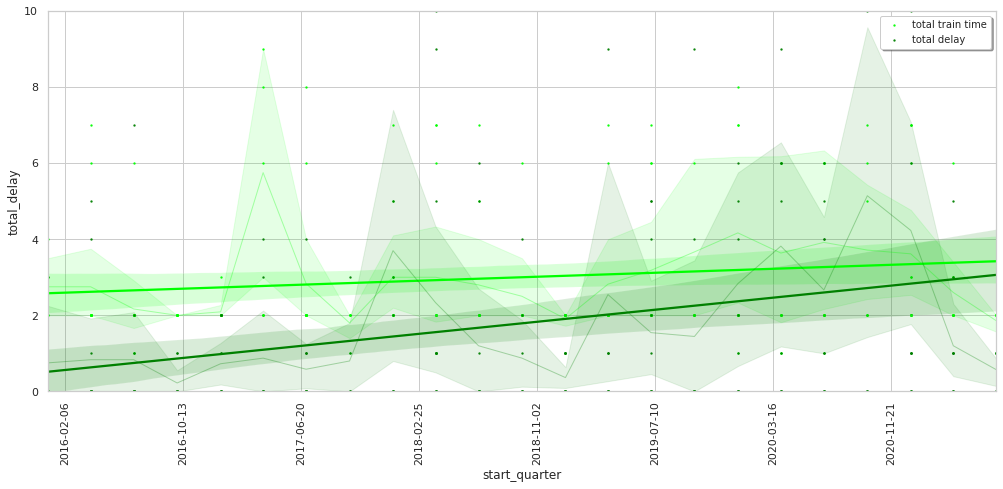

In [354]:
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(17, 7))

sns.regplot(x="start_quarter", y="train_total_time_days",data=traindata,color="lime", label="total train time",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="train_total_time_days",data=traindata,color="lime", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
sns.regplot(x="start_quarter", y="total_delay",data=traindata,color="green", label="total delay",scatter_kws={'s':2})
sns.lineplot(x="start_quarter", y="total_delay",data=traindata,color="green", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
ax.set_ylim([0,10])

x=plt.xticks(rotation=90)

In [355]:
import dateutil.relativedelta
semester=dateutil.relativedelta.relativedelta(months=6)
traindata["total_time_6months"]=[sum(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester))]["train_total_time_days_cont"])/len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester))]) for i in traindata["start_month_t"]]
traindata["total_delay_6months"]=[sum(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester))]["total_delay"])/len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester))]) for i in traindata["start_month_t"]]

### 2: Rolling average of total train time
#### When averaging the total train time and delay over 6-months rolling windows, we get signals that are a bit more stable, but major fluctuations still hold.

<Figure size 432x288 with 0 Axes>

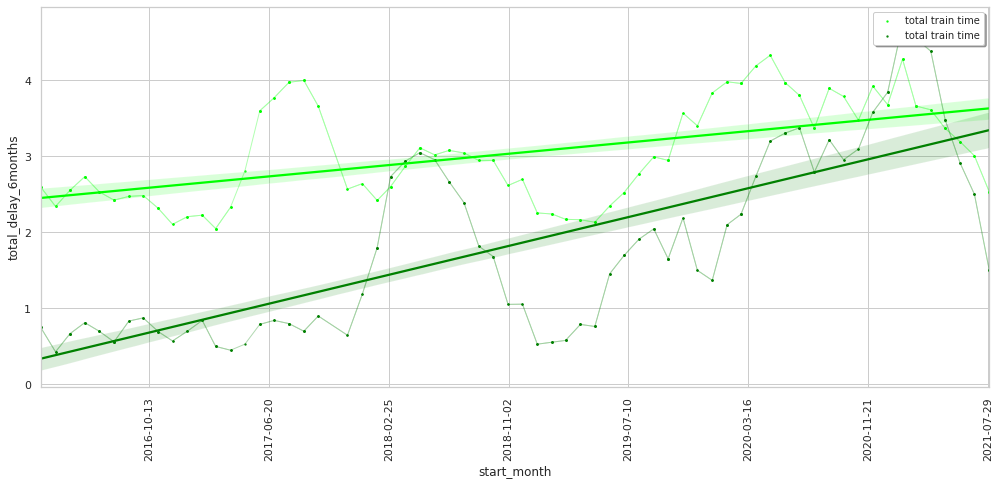

In [356]:
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(17, 7))

sns.regplot(x="start_month", y="total_time_6months",data=traindata,color="lime", label="total train time",scatter_kws={'s':2})
sns.lineplot(x="start_month", y="total_time_6months",data=traindata,color="lime", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
sns.regplot(x="start_month", y="total_delay_6months",data=traindata,color="green", label="total train time",scatter_kws={'s':2})
sns.lineplot(x="start_month", y="total_delay_6months",data=traindata,color="green", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
x=plt.xticks(rotation=90)

### 3: Rolling percentage of trains  lasting more than 2 / 4 days
For each month,  we count the number of trains in the past semester that exceeds  a threshold of 2 and 4 days, and average over the total number of trains in the past 6 months.

In [357]:

traindata["gt_4_trains_month"]=[len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester)) & (traindata["train_total_time_days"]>4)]["train_total_time_days_cont"])/len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester))]) for i in traindata["start_month_t"]]
#traindata["gt_4_trains_month"]=[sum(traindata[traindata["start_quarter"]==d]["train_total_time_days"]>4)/len(traindata[traindata["start_quarter"]==d]) if len(traindata[traindata["start_quarter"]==d])>0 else 0 for d in traindata["start_quarter"]] 

In [358]:
traindata["gt_2_trains_month"]=[len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester)) & (traindata["train_total_time_days"]>2)]["train_total_time_days_cont"])/len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester))]) for i in traindata["start_month_t"]]
#traindata["gt_2_trains_month"]=[sum(traindata[traindata["start_quarter"]==d]["train_total_time_days"]>2)/len(traindata[traindata["start_quarter"]==d]) if len(traindata[traindata["start_quarter"]==d])>0 else 0 for d in traindata["start_quarter"]] 

In [359]:
len(traindata[traindata["train_total_time_days"]>2])/len(traindata)

0.2290748898678414

In [360]:
len(traindata[traindata["train_total_time_days"]>4])/len(traindata)

0.1894273127753304

<Figure size 432x288 with 0 Axes>

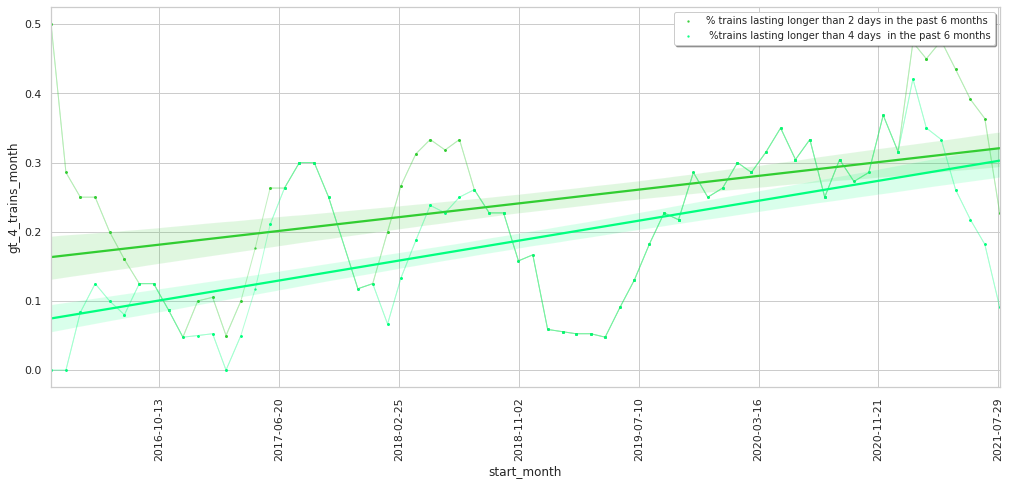

In [361]:
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(17, 7))

sns.regplot(x="start_month", y="gt_2_trains_month",data=traindata,color="limegreen", label="% trains lasting longer than 2 days in the past 6 months",scatter_kws={'s':2})
sns.lineplot(x="start_month", y="gt_2_trains_month",data=traindata,color="limegreen", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
sns.regplot(x="start_month", y="gt_4_trains_month",data=traindata,color="springgreen", label=" %trains lasting longer than 4 days  in the past 6 months",scatter_kws={'s':2})
sns.lineplot(x="start_month", y="gt_4_trains_month",data=traindata,color="springgreen", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
x=plt.xticks(rotation=90)

### 3: Rolling percentage of trains delaying more than 1 / 4 days
For each month,  we count the number of trains in the past semester whose delay exceeds  a threshold of 1 and 4 days, and average over the total number of trains in the past 6 months.

In [362]:
traindata["delay_4_trains_month"]=[len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester)) & (traindata["total_delay"]>4)]["total_delay"])/len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester))]) for i in traindata["start_month_t"]]
traindata["delay_2_trains_month"]=[len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester)) & (traindata["total_delay"]>2)]["total_delay"])/len(traindata[(traindata["start_month_t"]<=(i)) & (traindata["start_month_t"]>(i-semester))]) for i in traindata["start_month_t"]]


<Figure size 432x288 with 0 Axes>

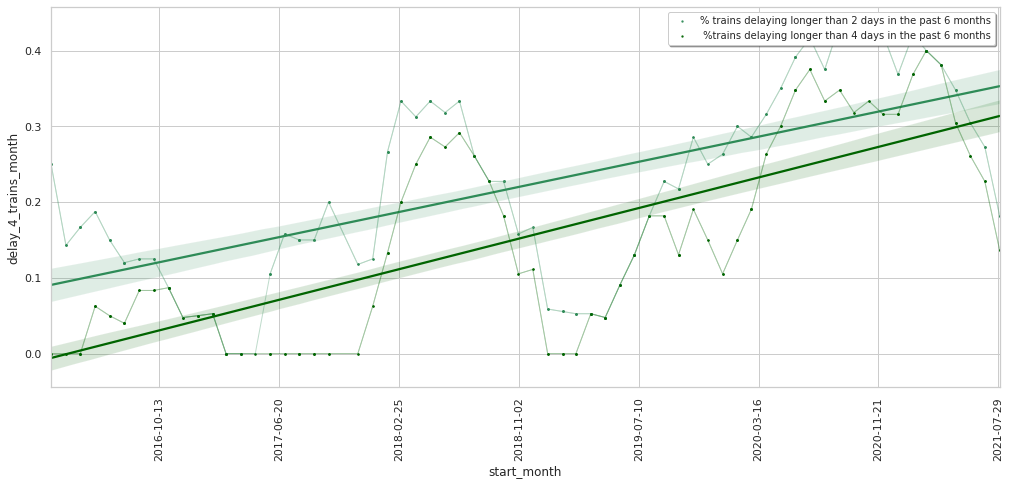

In [363]:
plt.clf()
sns.set(style="whitegrid")

fig,  ax= plt.subplots(figsize=(17, 7))

sns.regplot(x="start_month", y="delay_2_trains_month",data=traindata,color="seagreen", label="% trains delaying longer than 2 days in the past 6 months",scatter_kws={'s':2})
sns.lineplot(x="start_month", y="delay_2_trains_month",data=traindata,color="seagreen", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
sns.regplot(x="start_month", y="delay_4_trains_month",data=traindata,color="darkgreen", label=" %trains delaying longer than 4 days in the past 6 months",scatter_kws={'s':2})
sns.lineplot(x="start_month", y="delay_4_trains_month",data=traindata,color="darkgreen", linewidth=1,alpha=0.3,err_kws={'alpha':0.1})
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
x=plt.xticks(rotation=90)

### All Thresholds above can be changed to see what is the effect on the metric stability- time-based metrics seem to be less stable than blockers-base dmetrics.